In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()
t = np.linspace(-1, 1, 201)
x = (np.sin(2*np.pi*0.75*t*(1-t) + 2.1) +
     0.1*np.sin(2*np.pi*1.25*t + 1) +
     0.18*np.cos(2*np.pi*3.85*t))
xn = x + rng.standard_normal(len(t)) * 0.08

In [2]:
b, a = signal.butter(3, 0.05)

In [3]:
zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, xn, zi=zi*xn[0])

In [4]:
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])

In [5]:
y = signal.filtfilt(b, a, xn)

In [6]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [50]:
xn[30] += 3.0
xn[50] -= 1.0
o = running_mean(xn, 5)

In [8]:
o = np.hstack([xn[:4], o])

In [9]:
o.shape

(201,)

In [10]:
def ewma_vectorized_safe(data, alpha, row_size=None, dtype=None, order='C', out=None):
    """
    Reshapes data before calculating EWMA, then iterates once over the rows
    to calculate the offset without precision issues
    :param data: Input data, will be flattened.
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param row_size: int, optional
        The row size to use in the computation. High row sizes need higher precision,
        low values will impact performance. The optimal value depends on the
        platform and the alpha being used. Higher alpha values require lower
        row size. Default depends on dtype.
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Defaults to 'C'.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the desired output. If not provided or `None`,
        a freshly-allocated array is returned.
    :return: The flattened result.
    """
    data = np.array(data, copy=False)

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float
    else:
        dtype = np.dtype(dtype)

    row_size = int(row_size) if row_size is not None else get_max_row_size(alpha, dtype)

    if data.size <= row_size:
        # The normal function can handle this input, use that
        return ewma_vectorized(data, alpha, dtype=dtype, order=order, out=out)

    if data.ndim > 1:
        # flatten input
        data = np.reshape(data, -1, order=order)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    row_n = int(data.size // row_size)  # the number of rows to use
    trailing_n = int(data.size % row_size)  # the amount of data leftover
    first_offset = data[0]

    if trailing_n > 0:
        # set temporary results to slice view of out parameter
        out_main_view = np.reshape(out[:-trailing_n], (row_n, row_size))
        data_main_view = np.reshape(data[:-trailing_n], (row_n, row_size))
    else:
        out_main_view = out
        data_main_view = data

    # get all the scaled cumulative sums with 0 offset
    ewma_vectorized_2d(data_main_view, alpha, axis=1, offset=0, dtype=dtype,
                       order='C', out=out_main_view)

    scaling_factors = (1 - alpha) ** np.arange(1, row_size + 1)
    last_scaling_factor = scaling_factors[-1]

    # create offset array
    offsets = np.empty(out_main_view.shape[0], dtype=dtype)
    offsets[0] = first_offset
    # iteratively calculate offset for each row
    for i in range(1, out_main_view.shape[0]):
        offsets[i] = offsets[i - 1] * last_scaling_factor + out_main_view[i - 1, -1]

    # add the offsets to the result
    out_main_view += offsets[:, np.newaxis] * scaling_factors[np.newaxis, :]

    if trailing_n > 0:
        # process trailing data in the 2nd slice of the out parameter
        ewma_vectorized(data[-trailing_n:], alpha, offset=out_main_view[-1, -1],
                        dtype=dtype, order='C', out=out[-trailing_n:])
    return out

def get_max_row_size(alpha, dtype=float):
    assert 0. <= alpha < 1.
    # This will return the maximum row size possible on 
    # your platform for the given dtype. I can find no impact on accuracy
    # at this value on my machine.
    # Might not be the optimal value for speed, which is hard to predict
    # due to numpy's optimizations
    # Use np.finfo(dtype).eps if you  are worried about accuracy
    # and want to be extra safe.
    epsilon = np.finfo(dtype).tiny
    # If this produces an OverflowError, make epsilon larger
    return int(np.log(epsilon)/np.log(1-alpha)) + 1

In [11]:
def ewma_vectorized(data, alpha, offset=None, dtype=None, order='C', out=None):
    """
    Calculates the exponential moving average over a vector.
    Will fail for large inputs.
    :param data: Input data
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param offset: optional
        The offset for the moving average, scalar. Defaults to data[0].
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Defaults to 'C'.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the input. If not provided or `None`,
        a freshly-allocated array is returned.
    """
    data = np.array(data, copy=False)

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float64
    else:
        dtype = np.dtype(dtype)

    if data.ndim > 1:
        # flatten input
        data = data.reshape(-1, order)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    if data.size < 1:
        # empty input, return empty array
        return out

    if offset is None:
        offset = data[0]

    alpha = np.array(alpha, copy=False).astype(dtype, copy=False)

    # scaling_factors -> 0 as len(data) gets large
    # this leads to divide-by-zeros below
    scaling_factors = np.power(1. - alpha, np.arange(data.size + 1, dtype=dtype),
                               dtype=dtype)
    # create cumulative sum array
    np.multiply(data, (alpha * scaling_factors[-2]) / scaling_factors[:-1],
                dtype=dtype, out=out)
    np.cumsum(out, dtype=dtype, out=out)

    # cumsums / scaling
    out /= scaling_factors[-2::-1]

    if offset != 0:
        offset = np.array(offset, copy=False).astype(dtype, copy=False)
        # add offsets
        out += offset * scaling_factors[1:]

    return out

In [12]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

In [13]:
alpha = 0.9
result = numpy_ewma_vectorized_v2(xn, alpha)

In [54]:
yn = np.copy(xn)

In [89]:
xn = yn[15:31]

In [90]:
import pandas as pd

In [91]:
xn_rep = np.tile(xn, (2,1))

In [92]:
dfs = [pd.Series(xn) for xn in xn_rep]

In [96]:
results = [df.ewm(span=10).mean() for df in dfs]

In [97]:
t

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

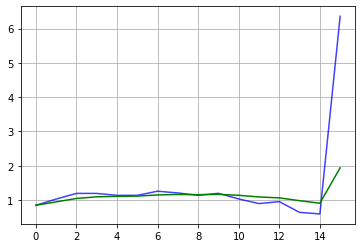

In [98]:
t = np.arange(xn.shape[0])
plt.figure
plt.plot(t, xn, 'b', alpha=0.75)
plt.plot(t, results[0], 'g')
# plt.plot(t, y, 'r', t, o, 'k', t, results[0], 'g')
# plt.legend(('noisy signal', 'lfilter, once', 'lfilter, twice',
#             'filtfilt'), loc='best')
plt.grid(True)
plt.show()